# Capstone Project 2
# How Soon Will a Complaint be Resolved?
## A Case Study on New York City 311 Call
## Final Report

Data Source: NYC Open Data - 311 Service Requests from 2010 to Present  
URL: https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9  
Analyst: Eugene Wen

### Background
New York City 311 call data is part of the NYC Opendata project that provides many interesting information about the 311 calls filing complaints to the NYPD. An important aspect is how fast an array of city agencies close the complaints.

This analysis attempted to predict, at the time of filing the complaint, how soon in average the case would be resolved (closed). Also, it would be interesting to find out which variable plays important role in the response time.

The full dataset in CSV format can be downloaded from NYC Opendata website.

### Subsample datasets for model development
First installed subsample package through pip, then changed directory to NYC311 data folder and run command as follows to randomly draw 50,000 rows:

`subsample -n 50000 311_Service_Requests_from_2010_to_Present.csv -r > nyc311_sample.csv`  

Note that this dataset is used for development. In the final report all 10GB data will be used for analysis.

In [1]:
# Load packages
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession

# Start a spark session
spark = SparkSession.builder.appName('nyc311').getOrCreate()

In [2]:
# Load sample dataset
df = spark.read.csv('../NYC311/nyc311_sample.csv', inferSchema=False, header=True)

### Data Wrangling

#### Derive the Target Variable: Response Time

The dataset includes two timestamp columns: Created Date, which indicates that when the case was created in the system, and Closed Data, which recorded when the case was resolved and closed. The difference between the two timestamps is the actual response time, i.e. how long it took to complete the case from filing time, in seconds.

For convenience, the response time in seconds was converted into days by applying the ceiling of the day fraction. If the case was resolved immediately, the response time in days would be 1 day.

In [5]:
# Calculate the response time as the difference between created date and closed date, in days.
# Also create a new variable HOD: hour of day for when the case was created.
from pyspark.sql.functions import unix_timestamp, floor, col, udf, date_format
from pyspark.sql.types import TimestampType, IntegerType
from datetime import datetime


fmt = "MM/dd/yyyy hh:mm:ss a"
starttime = unix_timestamp(df['Created Date'], format=fmt)
endtime = unix_timestamp(df['Closed Date'], format=fmt)

df = df.withColumn("Resp_time", floor((endtime - starttime)/86400) + 1)

dateConv = udf(lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p'), TimestampType())

df = df.withColumn("starttime", dateConv(col('Created Date')))
df = df.withColumn("call_hour_of_day", date_format("starttime" , "H")).drop("starttime")
df = df.withColumn("HOD", df["call_hour_of_day"].cast(IntegerType())).drop("call_hour_of_day")

df['Unique Key', 'Resp_time', 'Created Date', 'HOD'].show(10, truncate=False)

+----------+---------+----------------------+---+
|Unique Key|Resp_time|Created Date          |HOD|
+----------+---------+----------------------+---+
|32199603  |22       |12/14/2015 12:00:00 AM|0  |
|20074547  |2        |03/21/2011 04:22:49 PM|16 |
|28951515  |1        |09/25/2014 06:18:43 PM|18 |
|17575598  |5        |07/03/2010 10:11:00 AM|10 |
|28270434  |3        |06/16/2014 12:00:00 AM|0  |
|34115581  |13       |08/18/2016 02:24:21 PM|14 |
|28261221  |1        |06/14/2014 09:12:53 PM|21 |
|22829180  |2        |03/06/2012 12:05:20 PM|12 |
|29709630  |1        |01/13/2015 05:51:11 PM|17 |
|20809019  |8        |07/11/2011 12:00:00 AM|0  |
+----------+---------+----------------------+---+
only showing top 10 rows



#### Choice of  Variables

It is noticed that a number of variables have very little information, such as Taxi Company Borough and Road Ramp. These variables were dropped.

Also, Borough has general geographical information. Therefore, there was no need to keep the coordinate information unless for spatial analysis (which we won't conduct here anyway).

The variables Park Facility Name and starting with School, although seem to have quite rich information, have a major portion of "Unspecified" category which does not have useful information. These variables should also be dropped.

In [10]:
# Example of category distribution for Park Fercility Name
from pyspark.sql.functions import desc
df.groupby('Park Facility Name').count().sort(desc("count")).show(10)

+--------------------+-----+
|  Park Facility Name|count|
+--------------------+-----+
|         Unspecified|49653|
|        Central Park|   18|
|   Hudson River Park|    7|
|       Prospect Park|    7|
|      Riverside Park|    5|
|        Astoria Park|    4|
|Flushing Meadows ...|    4|
|      City Hall Park|    3|
|       John Jay Park|    3|
|     Alley Pond Park|    3|
+--------------------+-----+
only showing top 10 rows



In [14]:
# Choose the variables
df_input = df.select(["Unique Key", "Agency", "Complaint Type", "Status", "Borough", "Park Borough", "Resp_time", "HOD"])

#### Eliminate incorrectly parsed rows
A few rows were identified to be incorrectly parsed while reading in the CSV file. Given the very low number of problematic rows we decided to eliminate them from analysis.

See example below: the variable Park Borough in the original dataset was OK but the dataframe in memory has three rows that having mis-alignment issue.

In [15]:
df.groupby('Park Borough').count().sort(desc("count")).show(10)

+-------------+-----+
| Park Borough|count|
+-------------+-----+
|     BROOKLYN|14279|
|       QUEENS|10990|
|    MANHATTAN| 9794|
|        BRONX| 8480|
|  Unspecified| 4031|
|STATEN ISLAND| 2423|
|       225841|    1|
|       185215|    1|
|       195829|    1|
+-------------+-----+



In [17]:
df_input.filter("`Park Borough` == '225841'").show()

+----------+------+--------------+------+--------------------+------------+---------+---+
|Unique Key|Agency|Complaint Type|Status|             Borough|Park Borough|Resp_time|HOD|
+----------+------+--------------+------+--------------------+------------+---------+---+
|  18741880|   DEP|         Noise|Closed|11/04/2010 10:30:...|      225841|       43| 15|
+----------+------+--------------+------+--------------------+------------+---------+---+



In [18]:
# Drop the three rows with incorrect parsing
borough = {"BROOKLYN", "QUEENS", "MANHATTAN", "BRONX", "Unspecified", "STATEN ISLAND"}
df_input_clean = df_input.filter(df_input["Park Borough"].isin(borough) == True)

### Exploratory Data Analysis

In [19]:
# Plot response time distribution
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
df_input_pd = df_input_clean.toPandas()

We would like to check the distribution of the derived response time variable. It looks like there are some negative values!

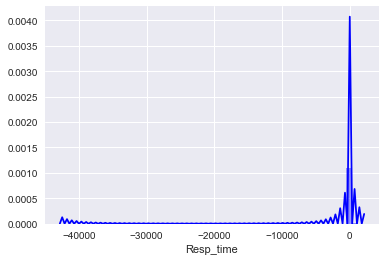

In [20]:
sns.set()
sns.distplot(df_input_pd.Resp_time.dropna(), kde=True, color='b')

A further drill down of these negative values and missing values showed that for some reason, about 5% data have Closed Data earlier than the Created Data, or missing the Closed Data (remains open). By looking up the website and related documentations, there apparently was neither clear explanation nor solution. We therefore decided to drop these rows.

In [25]:
df_input_clean.fillna(-99999, subset=['Resp_time']).filter("`Resp_time` == -99999").count()
df_input_clean = df_input_clean.filter("`Resp_time` > 0")

Plot the distribution of the response time again showed that the distribution is very skewed. We then tried to plot in log scale and the plot improved.

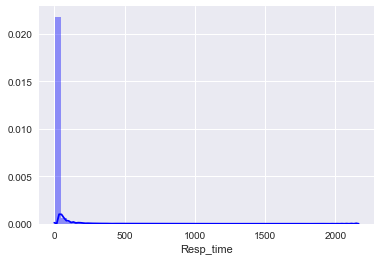

In [28]:
# Plot the distribution of response time again
sns.set()
sns.distplot(df_input_clean.toPandas().Resp_time, kde=True, color='b')

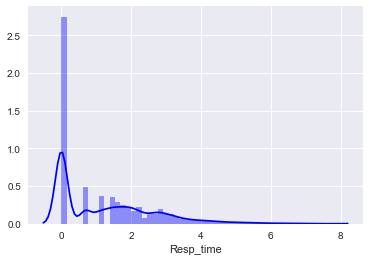

In [29]:
# Plot the distribution of response time again, with log transformation
sns.set()
sns.distplot(np.log(df_input_clean.toPandas().Resp_time), kde=True, color='b')

The log scale response time variable was created in the dataframe and will be used as the target variable.

In [30]:
# Create log scale response time instead for modeling
from pyspark.sql.functions import log
df_input_clean = df_input_clean.withColumn("log_Resp_time", log(df_input_clean.Resp_time))

As an alternative, we created a binary indicator named isLate for whether a case took more than one day to response and close, with 1 for cases took more than one day and 0 otherwise. The by-groupy count showed that it is well balanced.

In [31]:
# Create binary indicator of whether the response time takes more than 1 day
df_input_clean = df_input_clean.withColumn("isLate", (df_input_clean.Resp_time > 1).cast('integer'))
df_input_clean.groupby('isLate').count().show()

+------+-----+
|isLate|count|
+------+-----+
|     1|27535|
|     0|20066|
+------+-----+



### Machine Learning Models - Regression
In this section we attempted to build a regression model to predict the log-response time.

The models we tested including LinearRegression, GeneralizedLinearRegression, RandomForestRegressor and GBTRegressor. In general, based on the RMSE of test set, RandomeForestRegressor performed better. Therefore, we further tuned RandomForestRegressor on three major hyperparameters: number of trees, max depth and max bins.

In [32]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import mean

indexer1 = StringIndexer(inputCol="Agency", outputCol="AgencyVec")
indexer2 = StringIndexer(inputCol="Complaint Type", outputCol="CompTypeVec")
indexer3 = StringIndexer(inputCol="Borough", outputCol="BoroughVec")

assembler = VectorAssembler(inputCols=["AgencyVec", "CompTypeVec", "BoroughVec", "HOD"], outputCol='features')
pipeline = Pipeline(stages = [indexer1, indexer2, indexer3, assembler])
df_input_dense = pipeline.fit(df_input_clean).transform(df_input_clean)
df_input_final = df_input_dense.select(['features', 'log_Resp_time'])

In [33]:
# Split dataset into training and testing sets
train_data, test_data = df_input_final.randomSplit([0.7, 0.3])

In [37]:
# Import models to be used
from pyspark.ml.regression import LinearRegression, \
                                  RandomForestRegressor, \
                                  GBTRegressor, \
                                  GeneralizedLinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import mean

In [35]:
# Linear regression
lr = LinearRegression(featuresCol = 'features', \
                      labelCol = 'log_Resp_time', \
                      predictionCol = 'prediction')
lrModel = lr.fit(train_data)
test_results = lrModel.evaluate(test_data)
test_results.rootMeanSquaredError

1.3403156416899136

In [36]:
# Generalized Linear Regression
glm = GeneralizedLinearRegression(featuresCol='features',\
                                  labelCol='log_Resp_time', \
                                  predictionCol='prediction',\
                                  family="poisson", link="log")
glmModel = glm.fit(train_data)

# Evaluate on test set

test_results_glm = glmModel.transform(test_data)
test_results_glm = test_results_glm.withColumn("sqdiff", (test_results_glm["prediction"] - test_results_glm["log_Resp_time"])**2) 
RMSE_glm = test_results_glm.select(mean(test_results_glm["sqdiff"]))
RMSE_glm.show()

+------------------+
|       avg(sqdiff)|
+------------------+
|1.8184812090410245|
+------------------+



In [38]:
# Random Forest
rf = RandomForestRegressor(featuresCol='features',\
                           labelCol='log_Resp_time', \
                           predictionCol='prediction',\
                           numTrees=100, maxDepth=10, maxBins=250, seed=1000)
rfModel = rf.fit(train_data)

# Evaluate on test set

test_results_rf = rfModel.transform(test_data)
test_results_rf = test_results_rf.withColumn("sqdiff", (test_results_rf["prediction"] - test_results_rf["log_Resp_time"])**2)

from pyspark.sql.functions import mean
RMSE_rf = test_results_rf.select(mean(test_results_rf["sqdiff"]))
RMSE_rf.show()

+------------------+
|       avg(sqdiff)|
+------------------+
|0.8400397298122028|
+------------------+



In [39]:
# Gradient Boosting Tree
gbt = GBTRegressor(featuresCol='features',\
                   labelCol='log_Resp_time', \
                   predictionCol='prediction',\
                   maxIter=10, maxDepth=5, maxBins=500, seed=1000)
gbtModel = gbt.fit(train_data)

# Evaluate on test set

test_results_gbt = gbtModel.transform(test_data)
test_results_gbt = test_results_gbt.withColumn("sqdiff", (test_results_gbt["prediction"] - test_results_gbt["log_Resp_time"])**2)

RMSE_gbt = test_results_gbt.select(mean(test_results_gbt["sqdiff"]))
RMSE_gbt.show()

+------------------+
|       avg(sqdiff)|
+------------------+
|0.8571820331888391|
+------------------+



#### Tuning Random Forest Regressor
We picked two values for each of the three hyperparameters to test which combination would yield the best performance using default 3-fold cross validation. The results showed that at numTrees = 100, maxDepth = 10 and maxBins = 250, the model yielded the smallest RMSE on test data.

In [40]:
# Random Forest Tuning
rf = RandomForestRegressor(featuresCol='features',\
                           labelCol='log_Resp_time', \
                           predictionCol='prediction')
grid_rf = ParamGridBuilder().addGrid(rf.numTrees, [50, 100])\
                            .addGrid(rf.maxDepth, [5, 10]) \
                            .addGrid(rf.maxBins, [250, 500])\
                            .build()
eval_rf = RegressionEvaluator()
cv_rf = CrossValidator(estimator = rf, estimatorParamMaps=grid_rf, evaluator=eval_rf, parallelism=2)

train_data_cv = train_data.withColumn("label", train_data["log_Resp_time"])
cvModel1 = cv_rf.fit(train_data_cv)
cvModel1.avgMetrics

[0.9450642375223017,
 0.9450642375223017,
 0.9440638718862933,
 0.9440638718862933,
 0.9450337875150796,
 0.9450337875150796,
 0.9420461034207732,
 0.9420461034207732]

In [41]:
# Print out the hyperparameters of the best model
print(cvModel1.bestModel._java_obj.getNumTrees())
print(cvModel1.bestModel._java_obj.getMaxDepth())
print(cvModel1.bestModel._java_obj.getMaxBins())

100
10
250


#### Variable Importance
How importance is each of the predictor? We found that the most important variable is the complaint type, followed by agency. It seems making sense that depending on the type of complaint you filed, it might be complicated and needs more time to resolve, or could be a quite simple one like noise that usually would be resolved in an hour or so. 

Also, depending on which agency is handling your case, the response time may vary.

In [42]:
# Variable Importance
VI = pd.DataFrame(cvModel1.bestModel.featureImportances.toArray(), columns=["values"])
features_col = pd.Series(["AgencyVec", "CompTypeVec", "BoroughVec", "HOD"])  
VI["features"] = features_col
VI

,values,features
0,0.259539,AgencyVec
1,0.651528,CompTypeVec
2,0.022962,BoroughVec
3,0.065970,HOD


### Machine Learning Models -- Classification
As an alternative way to look into the problem, we attempted to predict whether a case would take more than one day to resolve (a binary indicator has been created above). This is a binary classification problem and the models we tested including Logistic Regression, RandomForestClassifier, GBTClassifer and NaiveBayes.

We took a similar approach that first testing the four models using mostly default hyperparameters (have to change the maxBins to accommodate the large category levels in Complaint Type). Then based on the test set performance we chose one to tune for better performance.

In [43]:
# Redo the assembling using the isLate binary indicator
indexer1 = StringIndexer(inputCol="Agency", outputCol="AgencyVec")
indexer2 = StringIndexer(inputCol="Complaint Type", outputCol="CompTypeVec")
indexer3 = StringIndexer(inputCol="Borough", outputCol="BoroughVec")

assembler = VectorAssembler(inputCols=["AgencyVec", "CompTypeVec", "BoroughVec", "HOD"], outputCol='features')
pipeline = Pipeline(stages = [indexer1, indexer2, indexer3, assembler])
df_input_dense = pipeline.fit(df_input_clean).transform(df_input_clean)
df_input_bin = df_input_dense.select(['features', 'isLate'])

In [44]:
# Split dataset into training and testing sets
train_data, test_data = df_input_bin.randomSplit([0.7, 0.3])

In [45]:
# Import classification models
from pyspark.ml.classification import LogisticRegression, \
                                      RandomForestClassifier, \
                                      GBTClassifier, \
                                      NaiveBayes
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [46]:
# Logistic Regression
lr = LogisticRegression(featuresCol='features',\
                        labelCol='isLate', \
                        predictionCol='prediction')
lrModel = lr.fit(train_data)

# Evaluate on test set

test_results_lr = lrModel.transform(test_data)
eval_lr = BinaryClassificationEvaluator(labelCol="isLate")
eval_lr.evaluate(test_results_lr)

0.7081004891992797

In [48]:
# Random Forest Classifier (increase maxBins to 250 to accommodate large number of category levels)
rfc = RandomForestClassifier(featuresCol='features',\
                             labelCol='isLate', \
                             predictionCol='prediction', \
                             numTrees=20, maxDepth=5, maxBins=250, seed=1000)
rfcModel = rfc.fit(train_data)

# Evaluate on test set

test_results_rfc = rfcModel.transform(test_data)
eval_rfc = BinaryClassificationEvaluator(labelCol="isLate")
eval_rfc.evaluate(test_results_rfc)

0.931315216849868

In [47]:
# GBT Classifier
gbtc = GBTClassifier(featuresCol='features',\
                     labelCol='isLate', \
                     predictionCol='prediction', \
                     maxIter=10, maxDepth=5, maxBins=250, seed=1000)
gbtcModel = gbtc.fit(train_data)

# Evaluate on test set

test_results_gbtc = gbtcModel.transform(test_data)
eval_gbtc = BinaryClassificationEvaluator(labelCol="isLate")
eval_gbtc.evaluate(test_results_gbtc)

0.9466875897327738

In [49]:
# Naive Bayes Classifier
nbc = NaiveBayes(featuresCol='features',\
                 labelCol='isLate', \
                 predictionCol='prediction')
nbcModel = nbc.fit(train_data)

# Evaluate on test set

test_results_nbc = nbcModel.transform(test_data)
eval_nbc = BinaryClassificationEvaluator(labelCol="isLate")
eval_nbc.evaluate(test_results_nbc)

0.5641498101464166

#### Tuen Gradient Boosting Tree Classifier
Both Randome Forest Classifier and GBT Classifier yielded quite good AUC results on test set. For demonstration we chose GBTClassifier to tune this time (showed RF tuning in regression section). The results showed that at maxIter = 20, maxDepth = 5 and maxBins = 250, the model yielded the highest AUC on test data.

In [50]:
# Tune GBTClassifier
gbtc = GBTClassifier(featuresCol='features',\
                     labelCol='isLate', \
                     predictionCol='prediction')
grid_gbtc = ParamGridBuilder().addGrid(gbtc.maxIter, [10, 20])\
                              .addGrid(gbtc.maxDepth, [5, 10]) \
                              .addGrid(gbtc.maxBins, [250, 500])\
                              .build()
eval_gbtc = BinaryClassificationEvaluator(labelCol="isLate")
cv_gbtc = CrossValidator(estimator = gbtc, estimatorParamMaps=grid_gbtc, evaluator=eval_gbtc, parallelism=2, numFolds=3)

train_data_cv = train_data.withColumn("label", train_data["isLate"])
cvModel2 = cv_gbtc.fit(train_data_cv)
cvModel2.avgMetrics

[0.9475146877280651,
 0.9475146877280649,
 0.9400934097272013,
 0.9400934097272015,
 0.9476015559521043,
 0.947601555952104,
 0.9397340615278416,
 0.9397340615278413]

In [51]:
print(cvModel2.bestModel._java_obj.getMaxIter())
print(cvModel2.bestModel._java_obj.getMaxDepth())
print(cvModel2.bestModel._java_obj.getMaxBins())

20
5
250


#### Variable Importance
How importance is each of the predictor? We found that the most important variable is the complaint type, followed by HOD. It seems making sense that depending on the type of complaint you filed, it might be complicated and needs more time to resolve, or could be a quite simple one like noise that usually would be resolved in an hour or so. 

Also, depending on when you call for help, the agency may be busy and therefore delay on response time .

In [52]:
# Variable Importance
VIC = pd.DataFrame(cvModel2.bestModel.featureImportances.toArray(), columns=["values"])
features_col = pd.Series(["AgencyVec", "CompTypeVec", "BoroughVec", "HOD"])  
VIC["features"] = features_col
VIC

,values,features
0,0.005244,AgencyVec
1,0.934895,CompTypeVec
2,0.020878,BoroughVec
3,0.038983,HOD


#### Results Visualization
How well is the accuracy of our prediction using the best GBT classifier?

A pivot table showed the confusion matrix and the computed accuracy is 88.3%. Because the binary cases are quite balanced, the accuracy is considered to be quite good.

In [54]:
test_results_final = cvModel2.bestModel.transform(test_data)
df = test_results_final["isLate", "prediction"].toPandas()
df["dummy"] = 1
pd.pivot_table(df, index=["isLate"], columns=["prediction"], values="dummy", aggfunc="count")

prediction,0.0,1.0
isLate,,
0,5004,1032
1,736,7672


In [55]:
accuracy = (4936+7695) / (4936+1074+598+7695)
accuracy

0.8831014472488289

In [ ]:
spark.stop()

### Conclusion
We found that using just a few variable we are able to predict whether a complaint case may be resolved within one day or tends to be delayed on response with 88% accuracy. Predicting the actual response time remains a challenge and quite intensive data cleaning is needed, especially those very lagged cases that took several months or even years to close. In general, ensemble tree models work better in building the predictive models. The complaint type is identified to be the most important variable, followed by the filing time (although much less impact comparing to complaint type), in determining the response time. 